In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
# Load RawData
raw_data = pd.read_csv('../Data/RawData.csv')

display(HTML('<span style="font-weight:bold;">Data Shape:</span> ' + str(raw_data.shape)))

pd.set_option('display.max_columns', None)
display(HTML('<span style="font-weight:bold;">Data Preview:</span>'))
display(raw_data.head().style.set_table_styles([{'selector': 'th.row_heading', 'props': [('min-width', '50px')]}]))
display(raw_data.tail().style.set_table_styles([{'selector': 'th.row_heading', 'props': [('min-width', '50px')]}]))

display(HTML('<span style="font-weight:bold;">Data Info:</span>'))
raw_data.info()

,economy,economycode,wpid_random,wgt,female,age,educ,inc_q,emp_in,urbanicity_f2f,account,account_fin,account_mob,fin1_1a,fin1_1b,fin2,fin4,fin4a,fin5,fin6,fin7,fin8,fin8a,fin8b,fin9,fin9a,fin10,fin10_1a,fin10_1b,fin10_1c,fin10_1d,fin10_1e,fin10a,fin10b,fin11_1,fin11a,fin11b,fin11c,fin11d,fin11e,fin11f,fin11g,fin11h,fin13a,fin13b,fin13c,fin13d,fin14_1,fin14_2,fin14_2_China,fin14a,fin14a1,fin14b,fin14c,fin14c_2,fin14c_2_China,fin16,fin17a,fin17a1,fin17b,fin20,fin22a,fin22b,fin22c,fin24,fin24a,fin24b,fin26,fin27_1,fin27c1,fin27c2,fin28,fin29_1,fin29c1,fin29c2,fin30,fin31a,fin31b,fin31b1,fin31b1_China,fin31c,fin32,fin33,fin34a,fin34b,fin34d,fin34e,fin35,fin37,fin38,fin39a,fin39b,fin39d,fin39e,fin42,fin42a,fin43a,fin43b,fin43d,fin43e,fin44a,fin44b,fin44c,fin44d,fin45,fin45_1,fin45_1_China,saved,borrowed,receive_wages,receive_transfers,receive_pension,receive_agriculture,pay_utilities,remittances,mobileowner,internetaccess,anydigpayment,merchantpay_dig
0,India,IND,199893106,0.325736,1,18,3,3,2,1,1,1,1,2.000000,1.000000,2,nan,nan,1.000000,1.000000,2.000000,nan,nan,nan,2.000000,nan,2.000000,nan,nan,nan,nan,nan,nan,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,2.000000,2.000000,1.000000,2,nan,nan,2,2,2,nan,nan,nan,2,2,2.000000,2,2,2,2,nan,4,2.000000,2.000000,2,nan,nan,nan,2,nan,nan,nan,1,2.000000,2.000000,nan,nan,1.000000,2,nan,nan,nan,nan,nan,nan,2,2,nan,nan,nan,nan,2,nan,nan,nan,nan,nan,2,2,2,2,4.000000,1,nan,0,0,4,4,4,4,2,5,1,1,1,0
1,India,IND,124497814,1.327328,2,41,1,1,2,2,1,1,0,1.000000,2.000000,2,nan,nan,2.000000,2.000000,2.000000,nan,nan,nan,2.000000,nan,2.000000,nan,nan,nan,nan,nan,nan,2.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2,nan,nan,2,2,2,nan,nan,nan,2,3,nan,2,2,2,2,nan,2,3.000000,1.000000,2,nan,nan,nan,2,nan,nan,nan,1,1.000000,2.000000,1.000000,nan,nan,2,nan,nan,nan,nan,nan,nan,2,2,nan,nan,nan,nan,2,nan,nan,nan,nan,nan,1,1,1,3,2.000000,1,nan,0,0,4,4,4,4,1,5,2,2,1,0
2,India,IND,183293857,1.461843,2,23,1,2,1,2,1,1,0,2.000000,2.000000,2,nan,nan,2.000000,2.000000,2.000000,nan,nan,nan,2.000000,nan,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,2.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2,nan,nan,2,2,2,nan,nan,nan,2,2,nan,2,1,2,1,nan,2,1.000000,4.000000,2,nan,nan,nan,2,nan,nan,nan,1,2.000000,2.000000,nan,nan,1.000000,1,2.000000,2.000000,2.000000,1.000000,nan,nan,2,2,nan,nan,nan,nan,2,nan,nan,nan,nan,nan,3,3,1,1,3.000000,2,nan,0,1,2,4,4,4,2,5,1,2,0,0
3,India,IND,152780466,0.390209,1,17,2,2,2,1,1,1,0,2.000000,1.000000,2,nan,nan,2.000000,2.000000,2.000000,nan,nan,nan,2.000000,nan,1.000000,nan,nan,nan,nan,nan,2.000000,2.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2,nan,nan,2,2,2,nan,nan,nan,2,2,nan,2,2,2,2,nan,3,1.000000,1.000000,2,nan,nan,nan,2,nan,nan,nan,2,nan,nan,nan,nan,nan,2,nan,nan,nan,nan,nan,nan,2,2,nan,nan,nan,nan,2,nan,nan,nan,nan,nan,1,1,1,1,4.000000,1,nan,0,0,4,4,4,4,4,5,1,2,0,0
4,India,IND,205473124,2.416927,2,27,1,1,1,2,1,1,0,1.000000,1.000000,2,nan,nan,2.000000,2.000000,2.000000,nan,nan,nan,2.000000,nan,1.000000,nan,nan,nan,nan,nan,2.000000,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2,nan,nan,2,2,2,nan,nan,nan,2,2,nan,1,2,2,2,2.000000,8,nan,nan,2,nan,nan,nan,2,nan,nan,nan,1,2.000000,2.000000,nan,nan,2.000000,2,nan,nan,nan,nan,nan,nan,1,2,2.000000,2.000000,2.000000,2.000000,2,nan,nan,nan,nan,nan,1,1,1,1,1.000000,1,nan,1,0,4,3,4,4,3,5,2,2,0,0


,economy,economycode,wpid_random,wgt,female,age,educ,inc_q,emp_in,urbanicity_f2f,account,account_fin,account_mob,fin1_1a,fin1_1b,fin2,fin4,fin4a,fin5,fin6,fin7,fin8,fin8a,fin8b,fin9,fin9a,fin10,fin10_1a,fin10_1b,fin10_1c,fin10_1d,fin10_1e,fin10a,fin10b,fin11_1,fin11a,fin11b,fin11c,fin11d,fin11e,fin11f,fin11g,fin11h,fin13a,fin13b,fin13c,fin13d,fin14_1,fin14_2,fin14_2_China,fin14a,fin14a1,fin14b,fin14c,fin14c_2,fin14c_2_China,fin16,fin17a,fin17a1,fin17b,fin20,fin22a,fin22b,fin22c,fin24,fin24a,fin24b,fin26,fin27_1,fin27c1,fin27c2,fin28,fin29_1,fin29c1,fin29c2,fin30,fin31a,fin31b,fin31b1,fin31b1_China,fin31c,fin32,fin33,fin34a,fin34b,fin34d,fin34e,fin35,fin37,fin38,fin39a,fin39b,fin39d,fin39e,fin42,fin42a,fin43a,fin43b,fin43d,fin43e,fin44a,fin44b,fin44c,fin44d,fin45,fin45_1,fin45_1_China,saved,borrowed,receive_wages,receive_transfers,receive_pension,receive_agriculture,pay_utilities,remittances,mobileowner,internetaccess,anydigpayment,merchantpay_dig
2995,India,IND,194627602,2.108736,2,65,1,1,1,2,1,1,0,1.000000,1.000000,2,nan,nan,1.000000,1.000000,2.000000,nan,nan,nan,2.000000,nan,2.000000,nan,nan,nan,nan,nan,nan,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2,nan,nan,1,2,2,nan,nan,nan,2,2,nan,2,1,1,1,nan,2,1.000000,1.000000,2,nan,nan,nan,2,nan,nan,nan,2,nan,nan,nan,nan,nan,1,2.000000,1.000000,2.000000,nan,nan,1.000000,1,2,2.000000,2.000000,2.000000,2.000000,2,nan,nan,nan,nan,nan,1,1,1,1,2.000000,1,nan,0,1,1,3,4,4,4,5,1,2,1,0
2996,India,IND,153300116,0.698285,2,32,1,5,1,2,1,1,0,2.000000,1.000000,1,2.000000,nan,2.000000,2.000000,2.000000,nan,nan,nan,1.000000,2.000000,2.000000,nan,nan,nan,nan,nan,nan,2.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2,nan,nan,2,2,2,nan,nan,nan,2,2,nan,2,2,2,2,nan,3,1.000000,2.000000,1,1.000000,nan,nan,2,nan,nan,nan,1,2.000000,2.000000,nan,nan,1.000000,2,nan,nan,nan,nan,nan,nan,2,2,nan,nan,nan,nan,2,nan,nan,nan,nan,nan,1,1,1,1,3.000000,1,nan,0,0,4,4,4,4,2,1,1,1,1,0
2997,India,IND,139817302,1.605233,2,18,2,2,1,2,0,0,0,nan,nan,2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,1.000000,nan,nan,nan,nan,2,nan,nan,2,2,2,nan,nan,nan,2,2,nan,2,2,2,2,nan,7,nan,nan,2,nan,nan,nan,2,nan,nan,nan,2,nan,nan,nan,nan,nan,2,nan,nan,nan,nan,nan,nan,2,2,nan,nan,nan,nan,2,nan,nan,nan,nan,nan,1,1,1,1,2.000000,1,nan,0,0,4,4,4,4,4,5,1,2,0,0
2998,India,IND,193692633,0.843446,2,36,2,4,1,2,1,1,0,1.000000,1.000000,1,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,nan,2.000000,2.000000,nan,2.000000,nan,nan,nan,nan,nan,nan,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2,1.000000,nan,2,2,2,nan,nan,nan,2,2,nan,2,1,2,1,nan,3,1.000000,1.000000,2,nan,nan,nan,2,nan,nan,nan,1,2.000000,2.000000,nan,nan,1.000000,2,nan,nan,nan,nan,nan,nan,2,2,nan,nan,nan,nan,2,nan,nan,nan,nan,nan,3,2,2,2,2.000000,2,nan,0,1,4,4,4,4,2,5,1,1,1,1
2999,India,IND,206115092,0.921741,2,48,3,5,1,2,1,1,0,2.000000,2.000000,2,nan,nan,2.000000,2.000000,2.000000,nan,nan,nan,2.000000,nan,2.000000,nan,nan,nan,nan,nan,nan,2.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2,nan,nan,2,1,1,2.000000,1.000000,nan,2,1,nan,2,2,2,2,nan,1,2.000000,1.000000,1,2.000000,2.000000,2.000000,2,nan,nan,nan,2,nan,nan,nan,nan,nan,2,nan,nan,nan,nan,nan,nan,1,2,2.000000,2.000000,2.000000,2.000000,2,nan,nan,nan,nan,nan,3,3,3,3,nan,2,nan,1,0,4,3,4,4,4,4,1,1,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Columns: 119 entries, economy to merchantpay_dig
dtypes: float64(71), int64(46), object(2)
memory usage: 2.7+ MB


**Insights:**
1. Data is Tidy.
2. Few Garbage variables. (eg. economy)
3. Many float type(71) variables just have integer values.
4. Presence of missing values and irrelevant variables. (eg. fin14c_2_China)

In [3]:
# Info table: variables, dtype, unique values, null values(%)

def dtype(col):      # If float column and all non-null values are integers, add signal
    dtype = raw_data[col].dtype.name
    if dtype == 'float64':
        vals = raw_data[col].dropna()
        if (vals % 1 == 0).all():
            return dtype + ' *'
    return dtype

info_table = pd.DataFrame({
    'Variables': raw_data.columns,
    'Dtype': [dtype(col) for col in raw_data.columns],
    'Unique Values': raw_data.nunique(),
    'Null Values (%)': (raw_data.isnull().sum().to_numpy() * 100 / len(raw_data)).round(2)
})
info_table.index = pd.RangeIndex(start=1, stop=len(info_table) + 1)
info_table

,Variables,Dtype,Unique Values,Null Values (%)
1,economy,object,1,0.0
2,economycode,object,1,0.0
3,wpid_random,int64,3000,0.0
4,wgt,float64,1628,0.0
5,female,int64,2,0.0
...,...,...,...,...
115,remittances,int64,6,0.0
116,mobileowner,int64,4,0.0
117,internetaccess,int64,3,0.0
118,anydigpayment,int64,2,0.0


**Insights:**
1. wpid_random -> 3000 unique values. (no duplicates)
2. Dtypes -> int and float. (object types are garbage)
3. Except wgt, all other float types have int values.
4. Majority of the variables can be excluded due to missing values.

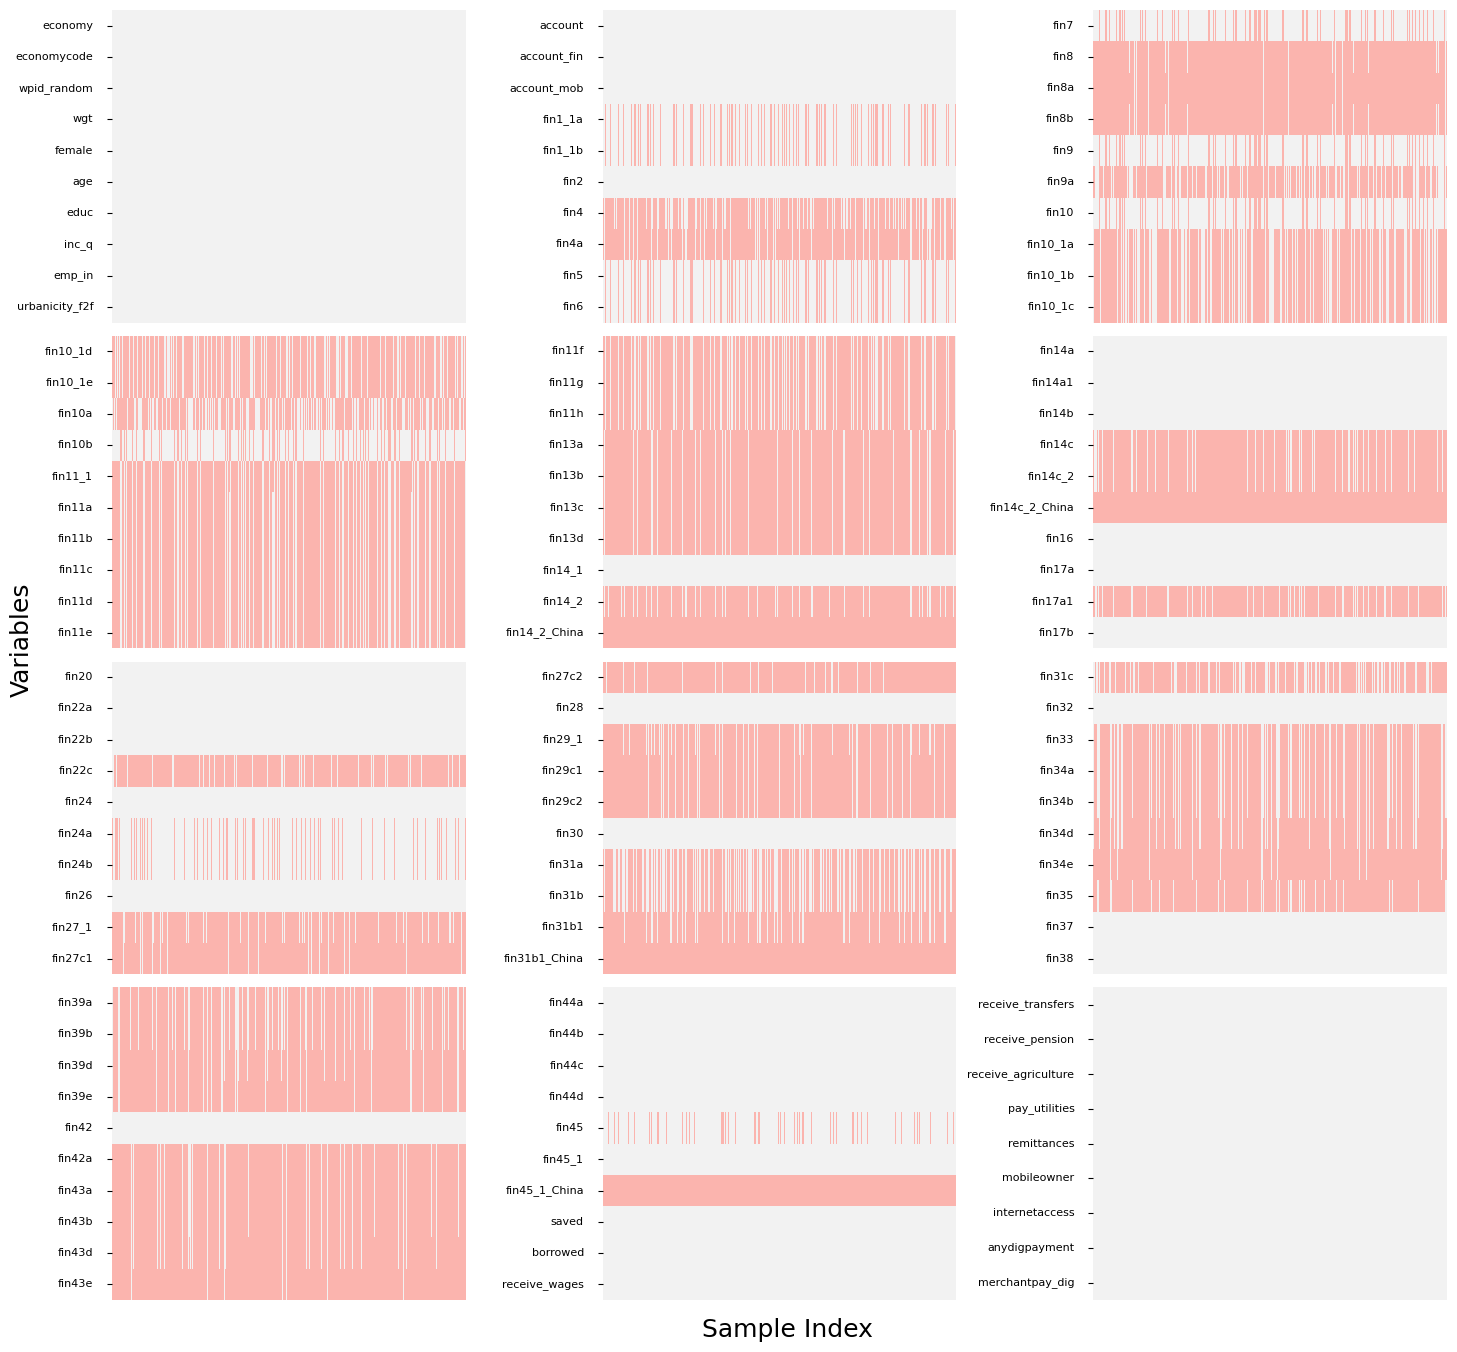

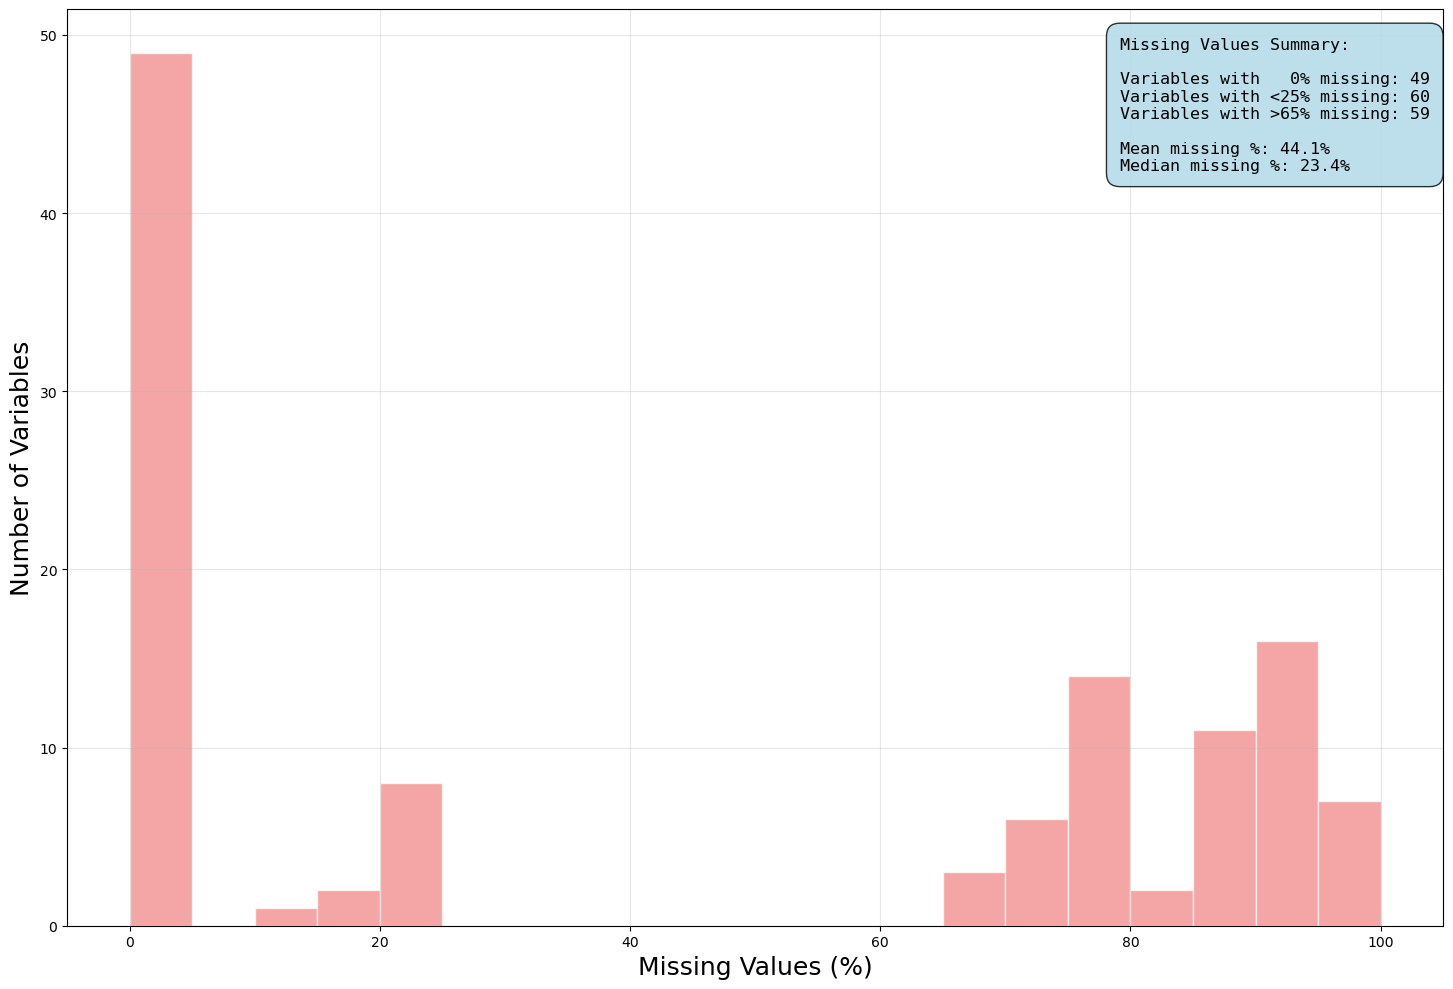

In [4]:
# Missing Values Visualization

# Heatmap Visualization
columns = raw_data.columns.tolist()     # Split them into 12 groups (4x3 layout)
n_cols = len(columns)
cols_per_plot = int(np.ceil(n_cols / 12))

fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.flatten()

for i in range(12):
    start_idx = i * cols_per_plot
    end_idx = min((i + 1) * cols_per_plot, n_cols)
    if start_idx < n_cols:
        subset_cols = columns[start_idx:end_idx]
        subset_data = raw_data[subset_cols]
        im = sns.heatmap(subset_data.isnull().T, 
                        cmap="Pastel1_r",
                        yticklabels=True,
                        xticklabels=False,
                        ax=axes[i],
                        cbar=False)
        axes[i].tick_params(axis='y', labelsize=8, pad=10)
        axes[i].tick_params(axis='x', labelsize=7)
    else:
        axes[i].set_visible(False)

fig.text(0.04, 0.5, 'Variables', ha='center', va='center', rotation='vertical', fontsize=18)
fig.text(0.55, 0.04, 'Sample Index', ha='center', va='center', fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.92, left=0.10, bottom=0.06)
plt.show()

# Histogram Visualization
missing_pct = (raw_data.isnull().sum() * 100 / len(raw_data)).to_numpy()
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

ax.hist(missing_pct, bins=20, color='lightcoral', alpha=0.7, edgecolor='white')
ax.set_xlabel('Missing Values (%)', fontsize=18)
ax.set_ylabel('Number of Variables', fontsize=18)
ax.grid(True, alpha=0.3)

summary_text = f"""Missing Values Summary:

Variables with   0% missing: {sum(missing_pct == 0)}
Variables with <25% missing: {sum(missing_pct < 25)}
Variables with >65% missing: {sum(missing_pct > 65)}

Mean missing %: {missing_pct.mean():.1f}%       
Median missing %: {np.median(missing_pct):.1f}%"""

# Position text box on the right side of the plot
ax.text(0.765, 0.97, summary_text, transform=ax.transAxes, 
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='lightblue', alpha=0.8),
        fontsize=12, fontfamily='monospace')

plt.tight_layout()
plt.show()

**Insights:**
1. 44.85% of the data is empty if garbage variables are excluded. (Mean - 44.1%)
2. Half of the features have missing values >23.4%. (Median)
3. 11 variables have missing values near 20%. [60(<25%)-49(0%)]

**Notes:**

Consider 11 variables with missing values for imputation, discard the rest.

In [5]:
# Variables with missing values <25%
missing_pct = (raw_data.isnull().sum() * 100 / len(raw_data))
variables = missing_pct[missing_pct < 25].sort_index()

grid = [["" for _ in range(6)] for _ in range(10)]
for i, n in enumerate(variables.index):
    r, c = divmod(i, 6)
    if r < 10:
        grid[r][c] = n
display(pd.DataFrame(grid).style.hide(axis="index").hide(axis="columns").set_table_styles([{"selector": "td", "props": [("border", "1px solid #d0d7de"), ("padding", "6px 8px")]}]))

variables_table = pd.DataFrame({
    'Variables': variables.index,
    'Dtype': [dtype(col) for col in variables.index],
    'Null Values (%)': np.round(variables.astype(float), 2)
})
variables_table.index = pd.RangeIndex(start=1, stop=len(variables_table) + 1)
variables_table

account,account_fin,account_mob,age,anydigpayment,borrowed
economy,economycode,educ,emp_in,female,fin10
fin10b,fin14_1,fin14a,fin14a1,fin14b,fin16
fin17a,fin17b,fin1_1a,fin1_1b,fin2,fin20
fin22a,fin22b,fin24,fin24a,fin24b,fin26
fin28,fin30,fin32,fin37,fin38,fin42
fin44a,fin44b,fin44c,fin44d,fin45,fin45_1
fin5,fin6,fin7,fin9,inc_q,internetaccess
merchantpay_dig,mobileowner,pay_utilities,receive_agriculture,receive_pension,receive_transfers
receive_wages,remittances,saved,urbanicity_f2f,wgt,wpid_random


,Variables,Dtype,Null Values (%)
1,account,int64,0.00
2,account_fin,int64,0.00
3,account_mob,int64,0.00
4,age,int64,0.00
5,anydigpayment,int64,0.00
6,borrowed,int64,0.00
7,economy,object,0.00
8,economycode,object,0.00
9,educ,int64,0.00
10,emp_in,int64,0.00


**Insights:**
1. All questionnaire variables(fin) are irrelavent, as they have been used to consturct other variables(account).
2. No Imputation required as missing data only belongs to questionnaire variables.
3. No issues with dtype on relavent variables. (one float, rest int)

**Notes:**

Drop garbage, questionnaire variables and round off wgi(float) to two decimal places.

In [6]:
# Drop Variables and round(2)-float variables
preprocessed_data = raw_data.drop(columns=['economy', 'economycode', 'wpid_random'] + [col for col in raw_data.columns if col.startswith('fin')])
preprocessed_data['wgt'] = preprocessed_data['wgt'].round(2)

display(HTML('<span style="font-weight:bold;">Data Shape:</span> ' + str(preprocessed_data.shape)))

pd.set_option('display.max_columns', None)
display(HTML('<span style="font-weight:bold;">Data Preview:</span>'))
display(preprocessed_data.head().style.set_table_styles([{'selector': 'th.row_heading', 'props': [('min-width', '50px')]}]))
display(preprocessed_data.tail().style.set_table_styles([{'selector': 'th.row_heading', 'props': [('min-width', '50px')]}]))

,wgt,female,age,educ,inc_q,emp_in,urbanicity_f2f,account,account_fin,account_mob,saved,borrowed,receive_wages,receive_transfers,receive_pension,receive_agriculture,pay_utilities,remittances,mobileowner,internetaccess,anydigpayment,merchantpay_dig
0,0.330000,1,18,3,3,2,1,1,1,1,0,0,4,4,4,4,2,5,1,1,1,0
1,1.330000,2,41,1,1,2,2,1,1,0,0,0,4,4,4,4,1,5,2,2,1,0
2,1.460000,2,23,1,2,1,2,1,1,0,0,1,2,4,4,4,2,5,1,2,0,0
3,0.390000,1,17,2,2,2,1,1,1,0,0,0,4,4,4,4,4,5,1,2,0,0
4,2.420000,2,27,1,1,1,2,1,1,0,1,0,4,3,4,4,3,5,2,2,0,0


,wgt,female,age,educ,inc_q,emp_in,urbanicity_f2f,account,account_fin,account_mob,saved,borrowed,receive_wages,receive_transfers,receive_pension,receive_agriculture,pay_utilities,remittances,mobileowner,internetaccess,anydigpayment,merchantpay_dig
2995,2.110000,2,65,1,1,1,2,1,1,0,0,1,1,3,4,4,4,5,1,2,1,0
2996,0.700000,2,32,1,5,1,2,1,1,0,0,0,4,4,4,4,2,1,1,1,1,0
2997,1.610000,2,18,2,2,1,2,0,0,0,0,0,4,4,4,4,4,5,1,2,0,0
2998,0.840000,2,36,2,4,1,2,1,1,0,0,1,4,4,4,4,2,5,1,1,1,1
2999,0.920000,2,48,3,5,1,2,1,1,0,1,0,4,3,4,4,4,4,1,1,1,0


**Insights:**
1. All are integer encoded categorical variables (except age). 
2. Some variables are redundant as per research question. (target variable -> account)


**Notes:**

Discard variables redundant for research question and rename the features.

In [7]:
# Discard Redundant Variables and Rename Features
preprocessed_data.drop(columns=['account_fin', 'account_mob', 'anydigpayment', 'merchantpay_dig'], inplace=True)
preprocessed_data.rename(columns={
    'female': 'gender',
    'age': 'age',
    'educ': 'ed_lvl',
    'inc_q': 'income_q',
    'emp_in': 'employed',
    'urbanicity_f2f': 'rural',
    'mobileowner': 'mobile',
    'internetaccess': 'internet',
    'saved': 'savings',
    'borrowed': 'loans',
    'pay_utilities': 'utilities',
    'remittances': 'remittances',
    'receive_wages': 'wages',
    'receive_transfers': 'transfers',
    'receive_pension': 'pension',
    'receive_agriculture': 'agri_sale'
}, inplace=True)

display(HTML('<span style="font-weight:bold;">Data Shape:</span> ' + str(preprocessed_data.shape)))
display(HTML('<span style="font-weight:bold;">Data Overview:</span>'))
print(f"Total Variables: {len(preprocessed_data.columns)}")
print(f"Categorical Variables: {len([col for col in preprocessed_data.columns if col not in ['age', 'wgt']])} (Binary/Cardinal/Ordinal)")
print(f"Continuous Variables: {len(['age'])} (Age)")
print(f"Survey Weights: wgt")

display(HTML('<span style="font-weight:bold;">Data Preview:</span>'))
display(preprocessed_data.head().style.set_table_styles([{'selector': 'th.row_heading', 'props': [('min-width', '50px')]}]))
display(preprocessed_data.tail().style.set_table_styles([{'selector': 'th.row_heading', 'props': [('min-width', '50px')]}]))

display(HTML('<span style="font-weight:bold;">Data Info:</span>'))

info_table = pd.DataFrame({
    'Variables': preprocessed_data.columns,
    'Dtype': preprocessed_data.dtypes,
    'Unique Values': preprocessed_data.nunique(),
    'Null Values (%)': (preprocessed_data.isnull().sum().to_numpy() * 100 / len(preprocessed_data)).round(2)
})
info_table.index = pd.RangeIndex(start=1, stop=len(info_table) + 1)
info_table

Total Variables: 18
Categorical Variables: 16 (Binary/Cardinal/Ordinal)
Continuous Variables: 1 (Age)
Survey Weights: wgt


,wgt,gender,age,ed_lvl,income_q,employed,rural,account,savings,loans,wages,transfers,pension,agri_sale,utilities,remittances,mobile,internet
0,0.330000,1,18,3,3,2,1,1,0,0,4,4,4,4,2,5,1,1
1,1.330000,2,41,1,1,2,2,1,0,0,4,4,4,4,1,5,2,2
2,1.460000,2,23,1,2,1,2,1,0,1,2,4,4,4,2,5,1,2
3,0.390000,1,17,2,2,2,1,1,0,0,4,4,4,4,4,5,1,2
4,2.420000,2,27,1,1,1,2,1,1,0,4,3,4,4,3,5,2,2


,wgt,gender,age,ed_lvl,income_q,employed,rural,account,savings,loans,wages,transfers,pension,agri_sale,utilities,remittances,mobile,internet
2995,2.110000,2,65,1,1,1,2,1,0,1,1,3,4,4,4,5,1,2
2996,0.700000,2,32,1,5,1,2,1,0,0,4,4,4,4,2,1,1,1
2997,1.610000,2,18,2,2,1,2,0,0,0,4,4,4,4,4,5,1,2
2998,0.840000,2,36,2,4,1,2,1,0,1,4,4,4,4,2,5,1,1
2999,0.920000,2,48,3,5,1,2,1,1,0,4,3,4,4,4,4,1,1


,Variables,Dtype,Unique Values,Null Values (%)
1,wgt,float64,212,0.0
2,gender,int64,2,0.0
3,age,int64,70,0.0
4,ed_lvl,int64,5,0.0
5,income_q,int64,5,0.0
6,employed,int64,2,0.0
7,rural,int64,2,0.0
8,account,int64,2,0.0
9,savings,int64,2,0.0
10,loans,int64,2,0.0


In [8]:
# Export the data to CSV in the Data directory
preprocessed_data.to_csv('../Data/PreProcessedData.csv', index=False)

**Preprocessed Data:**

Removed Variables:
1. Gabage variables - economy, economycode
2. Irrelavent variables - questionnaire variables(fin..)
3. Redundant variables - based on research question(account_fin, account_mob, anydigpayment, merchantpay_dig)

Variable wgi(only float type) rounded to two decimal places.
Renamed features according to convinience.
Rest data is tidy and they do not contain missing values/duplicates.

<div style="font-family: 'Inter', sans-serif;border-radius: 8px;line-height: 1.5;
font-size: 14px;max-width: 950px;scale: 0.95;
">

  <div style="font-weight:600; margin-bottom:6px; font-size:15px">
    Target Variable: <span style="font-weight:400;">account</span>
  </div>

  <div style="font-size:16px; font-weight:700; color:#f1c40f; margin-bottom:10px;">
    Features
  </div>

  <div style="display:grid; grid-template-columns: repeat(auto-fit, minmax(260px, 1fr)); gap: 18px;">

<!-- Demographics -->
<div>
    <div style="font-weight:600; color:#00adb5; margin-bottom:4px;">Demographics</div>
    <ul style="margin:0 0 0 18px; padding:0;">
    <li>female <span style="color:gray;">(gender)</span></li>
    <li>age</li>
    <li>educ <span style="color:gray;">(ed_lvl)</span></li>
    </ul>
</div>

<!-- Socioeconomic -->
<div>
    <div style="font-weight:600; color:#00adb5; margin-bottom:4px;">Socioeconomic</div>
    <ul style="margin:0 0 0 18px; padding:0;">
    <li>inc_q <span style="color:gray;">(income_q)</span></li>
    <li>emp_in <span style="color:gray;">(employed)</span></li>
    <li>urbanicity_f2f <span style="color:gray;">(rural)</span></li>
    </ul>
</div>

<!-- Technology / Access -->
<div>
    <div style="font-weight:600; color:#00adb5; margin-bottom:4px;">Technology / Access</div>
    <ul style="margin:0 0 0 18px; padding:0;">
    <li>mobileowner <span style="color:gray;">(mobile)</span></li>
    <li>internetaccess <span style="color:gray;">(internet)</span></li>
    </ul>
</div>

  </div>

  <!-- Financial Section -->
  <div style="margin-top:14px;">
    <div style="font-weight:600; color:#00adb5; margin:8px 0 4px 0;">Financial [past year]</div>
    <ul style="
      margin: 0;
      padding: 0;
      list-style-type: disc;
      display: grid;
      grid-template-columns: repeat(auto-fit, minmax(200px, 1fr));
      column-gap: 12px;
      row-gap: 4px;
      padding-left: 20px;
    ">
      <li>saved</li>
      <li>borrowed</li>
      <li>pay_utilities <span style="color:gray;">(utilities)</span></li>
      <li>remittances</li>
      <li>receive_wages <span style="color:gray;">(wages)</span></li>
      <li>receive_transfers <span style="color:gray;">(transfers)</span></li>
      <li>receive_pension <span style="color:gray;">(pension)</span></li>
      <li>receive_agriculture <span style="color:gray;">(agri_sale)</span></li>
    </ul>
  </div>

  <!-- Note -->
  <div style="margin-top: 14px; padding: 5px 10px; border-left: 3px solid #ffcc00;">
    <span style="opacity:0.85;">
      The wgt variable contains survey weights that should be used for accurate population-representative analysis. Survey weights adjust for sampling design, non-response bias, and post-stratification. 
    </span>
  </div>

</div>